# Mini-Xrays: From Folders

Replicating Lesson 1 from Fastai part1 v1 and v2, using [mini-xray dataset](https://www.kaggle.com/kmader/create-a-mini-xray-dataset-standard/data) instead of Dogs and Cats. This notebook details a binary classification problem of normal and abnormal x-rays. The images are extracted and stored in `data/train` and `data/valid`. It is an imbalance dataset with 91% of images belonging to abnormal class.

## Imports

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

#usual stuff
from tqdm import trange
from datetime import datetime
import random
import math
from collections import Counter, namedtuple
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import dill as pickle
import glob
import shutil
from PIL import Image as pil_image
import warnings
warnings.filterwarnings("ignore")

#utils
import h5py

#fastai
import fastai
from fastai import *         
from fastai.vision import * 

#paths
DATA_PATH = 'data/'
TRAIN_PATH = f'{DATA_PATH}train/'
VALID_PATH = f'{DATA_PATH}valid/'
RAW_PATH = f'{DATA_PATH}raw/'
MODEL_PATH = f'{DATA_PATH}models/'

#check cuda
print(f'PyTorch version {torch.version.__version__}')
print(f'CUDA is {torch.cuda.is_available()}')
print(f'CuDnn is {torch.backends.cudnn.enabled}')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

PyTorch version 1.0.0.dev20180929
CUDA is True
CuDnn is True


## Process Data

Exract the [mini-xray dataset](https://www.kaggle.com/kmader/create-a-mini-xray-dataset-standard/data) downloaded as `chest_xray.h5`.

In [2]:
# with h5py.File(f'{DATA_PATH}chest_xray.h5', 'r') as h5_data:
#     for c_key in h5_data.keys():
#         print(c_key, h5_data[c_key].shape, h5_data[c_key].dtype)

In [3]:
# result = []
# with h5py.File(f'{DATA_PATH}chest_xray.h5', 'r') as h5_data:
#     images = h5_data['images'].value
#     fnames = h5_data['path'].value
#     targets = h5_data['Finding Labels'].value

In [4]:
# # extract metadata
# meta = []
# for i in range(len(fnames)):
#     meta.append({'fname':fnames[i].astype(str).split('/')[-1],'target':targets[i].astype(str)})
# meta = pd.DataFrame(meta)
# meta['target'] = meta['target'].map(lambda x: str(x).replace('|', ' '))
# meta['flag'] = meta['target'].map(lambda x: 1 if x else 0)
# meta.to_csv(f'{DATA_PATH}labels.csv',index=False)
meta = pd.read_csv(f'{DATA_PATH}labels.csv')
meta.head()

,fname,target,flag
0,00020213_066.png,Infiltration,1
1,00030279_000.png,Atelectasis Cardiomegaly,1
2,00005490_001.png,Atelectasis Consolidation Pneumothorax,1
3,00013472_002.png,Atelectasis Consolidation Effusion Infiltratio...,1
4,00005089_035.png,Effusion,1


In [5]:
# #extract images
# for i in range(len(fnames)):
#     to_save = pil_image.fromarray(images[i].reshape(128,128)).convert('RGB')
#     fname = fnames[i].astype(str).split('/')[-1]
#     to_save.save(f'{RAW_PATH}{fname}')

In [6]:
#test train split
from sklearn.model_selection import train_test_split
fname_train, fname_valid, y_train, y_valid = train_test_split(meta.fname, meta.flag, 
                                                              test_size=0.2, random_state=1412)
print(f'Train set: {Counter(y_train)}; Test set: {Counter(y_valid)}')
print(f'Baseline accuracy: {Counter(y_train)[1] / (Counter(y_train)[0] + Counter(y_train)[1])}')

Train set: Counter({1: 13200, 0: 1200}); Test set: Counter({1: 3317, 0: 283})
Baseline accuracy: 0.9166666666666666


In [7]:
# for i in y_train.index:
#     f = fname_train[i]
#     shutil.copy(f'{RAW_PATH}{f}', f'{TRAIN_PATH}{y_train[i]}/{f}')
# for i in y_valid.index:
#     f = fname_valid[i]
#     shutil.copy(f'{RAW_PATH}{f}', f'{VALID_PATH}{y_valid[i]}/{f}')

## Data Bunch

Create `DataBunch` object with selected transformations, size and batch size.

In [8]:
#transformation
tfms = [flip_lr(p=0.5),
        rotate(degrees=(-10,10), p=0.5), 
        rand_zoom(scale=(1.,1.1), p=0.75), 
        contrast(scale=(0.8, 1/0.8), p=0.75)]

#get data bunch
data = ImageDataBunch.from_folder(DATA_PATH, #data path
                                  ds_tfms=(tfms, []),  #data transformation from train / valid
                                  size = 128, bs = 64)

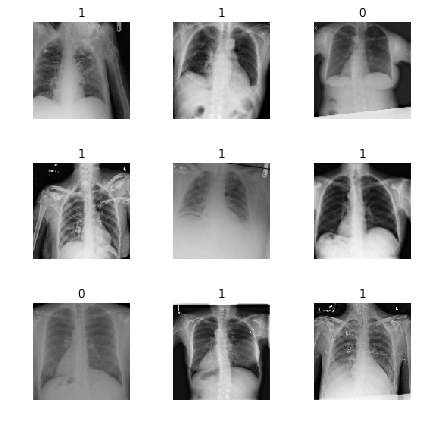

In [9]:
img,label = data.train_dl.one_batch()
show_images(img.cpu(), label.cpu(), 3, data.train_ds.classes, figsize=(6,6))

In [10]:
#normalize images
data.normalize(imagenet_stats)

## Learner

Select maximum learning rates and weight decays. Load pretrained models. Warm up with one epoch then unfreeze and train all layers.

In [11]:
opt_fn = partial(optim.Adam, betas=(0.9, 0.99))
loss_fn = partial(F.cross_entropy, #loss type 
                  weight = torch.FloatTensor([0.9,0.1]).to(device) #weight for each class
                 ) 
learn = ConvLearner(data, tvm.resnet34, metrics=[accuracy])
learn.opt_fn = opt_fn
learn.loss_fn = loss_fn

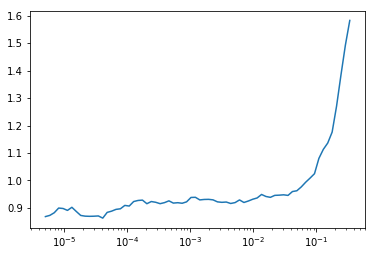

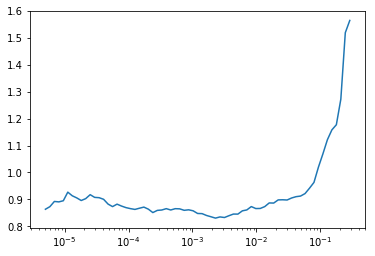

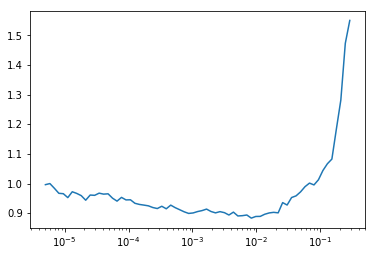

In [12]:
#select weight decays and lrs
wds = [1e-6,1e-4,1e-2]
for wd in wds:
    learn.wd = wd
    learn.lr_find(start_lr = 1e-6, end_lr = 1e1)
    learn.recorder.plot()

In [13]:
wd = 1e-6
wds = (wd/1e4, wd/1e4, wd)
lr = 0.08 / 10
lrs = (lr/1e3,lr/1e3,lr)

In [14]:
learn.fit_one_cycle(cyc_len = 1, 
                    max_lr=lrs, #discriminative learning rates
                    moms = (0.95,0.85), #momentums
                    div_factor=25, #factor to discount from max
                    pct_start = 0.3, #where the peak is at 
                    wd=wds #discriminative weight decays
                   ) 

Total time: 00:43
epoch  train loss  valid loss  accuracy
0      0.704924    0.572573    0.716944  (00:43)



In [15]:
learn.unfreeze()
learn.fit_one_cycle(10, max_lr=lrs, moms = (0.95,0.85), div_factor=25, pct_start = 0.3, wd=wds)

Total time: 09:45
epoch  train loss  valid loss  accuracy
0      0.666760    0.552637    0.725278  (00:58)
1      0.688235    0.570736    0.703056  (00:58)
2      0.658828    0.493226    0.786944  (00:58)
3      0.618067    0.433472    0.813889  (00:58)
4      0.588762    0.521700    0.737222  (00:58)
5      0.595318    0.551780    0.716111  (00:58)
6      0.547865    0.488073    0.761389  (00:58)
7      0.545845    0.522667    0.725000  (00:58)
8      0.528441    0.480088    0.759722  (00:58)
9      0.546944    0.465307    0.772778  (00:58)



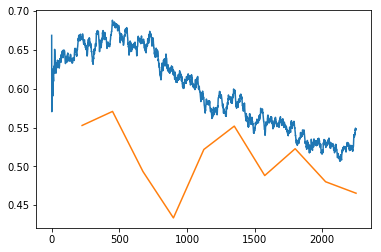

In [16]:
learn.recorder.plot_losses()

## Evaluation

In [23]:
preds,y = learn.TTA() #test time augmentation
# preds,y = learn.get_preds() #no test time augmentation

Total time: 00:42



In [24]:
accuracy(preds,y), fbeta(preds,y.reshape(-1,1), beta=2), fbeta(preds,y.reshape(-1,1), beta=1)

(tensor(0.8589), tensor(0.9352), tensor(0.9270))

In [25]:
interp = ClassificationInterpretation(data, preds, y, loss_class=nn.CrossEntropyLoss)

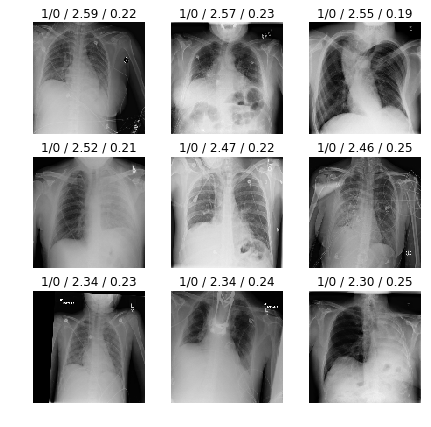

In [26]:
interp.plot_top_losses(9, figsize=(7,7))

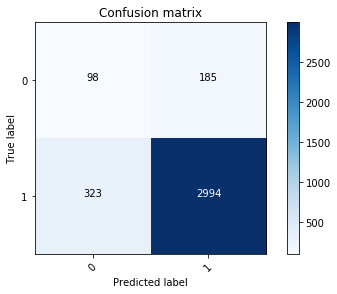

In [27]:
interp.plot_confusion_matrix()